Origin-destination matrices comparisons

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

import computing_functions

In [3]:
ksh_stats = pd.read_csv("data/sources/KSH/KSHSettlList_settlID_settlname_pop_lat_lon.csv")
ksh_flows_16 = pd.read_csv("data/sources/KSH/flows_16_cities.csv")
gravity_base = pd.read_csv("computing/odm/ODM_16_cities_gravity_unfitted.csv")
gravity_fitted = pd.read_csv("computing/odm/ODM_16_cities_gravity_fitted.csv")
entopy_max = (pd.read_csv("computing/odm/ODM_16_cities_entropy_max.csv")).rename(columns={"ODM_value": "flow"})
entopy_min = (pd.read_csv("computing/odm/ODM_16_cities_entropy_min.csv")).rename(columns={"ODM_value": "flow"})
cities = ['Budapest', 'Kecskemét', 'Szeged', 'Szolnok', 'Debrecen', 'Nyíregyháza', 'Miskolc', 'Dunaújváros', 'Szekszárd', 'Pécs', 'Székesfehérvár', 'Siófok', 'Győr', 'Sopron', 'Szombathely', 'Veszprém']

def replace_letters(s):
    return s.replace("õ", "ő").replace("Õ", "Ő").replace("û", "ű").replace("Û", "Ű")
#non_english_letters = r'[^a-zA-Z]'; non_hungarian_letters = r'[^a-zA-ZáéíóöőúüűÁÉÍÓÖŐÚÜŰ]'
#non_hungarian = ksh_stats['Settlement_Name'].str.contains(non_hungarian_str, regex=True)
ksh_stats['Settlement_Name'] = ksh_stats['Settlement_Name'].apply(replace_letters)

In [4]:
ksh_flows_16_nondiagonal = ksh_flows_16.copy()
for i, row in ksh_flows_16_nondiagonal.iterrows():
    if row['origin'] == row['destination']:
        ksh_flows_16_nondiagonal.loc[i, "flow"] = 0

In [5]:
def generate_id_dicts(ksh_flows_dir, origin_column_name='origName',origin_column_ID ='origID'):
    place_id_dict = {}
    for key, value in zip(ksh_flows_dir[origin_column_name], ksh_flows_dir[origin_column_ID]):
        if key in place_id_dict.keys():
            if place_id_dict[key] != value:
                print(key), print(value), print(place_id_dict[key])
        else:
            place_id_dict[key] = value
    place_id_dict['Budapest'] = 13578
    id_place_dict = { v:k for k, v in place_id_dict.items()}
    return place_id_dict, id_place_dict

place_id_dict, id_place_dict = generate_id_dicts(ksh_stats, 'Settlement_Name', 'Settlement_ID')

In [6]:
odm_2d = computing_functions.odm_ids_df_to_odm_2d_symmetric(ksh_flows_16,id_place_dict, cities)
odm_2d_nondiagonal = computing_functions.odm_ids_df_to_odm_2d_symmetric(ksh_flows_16_nondiagonal,id_place_dict, cities)

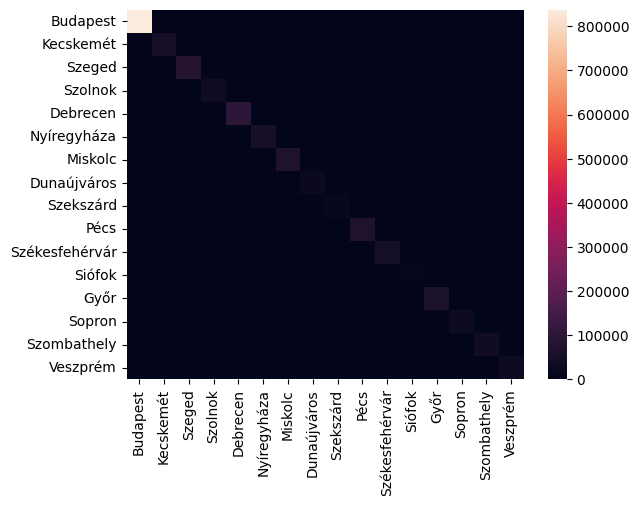

In [7]:
computing_functions.plot_odm(odm_2d, cities,)

Excluding the diagonal:

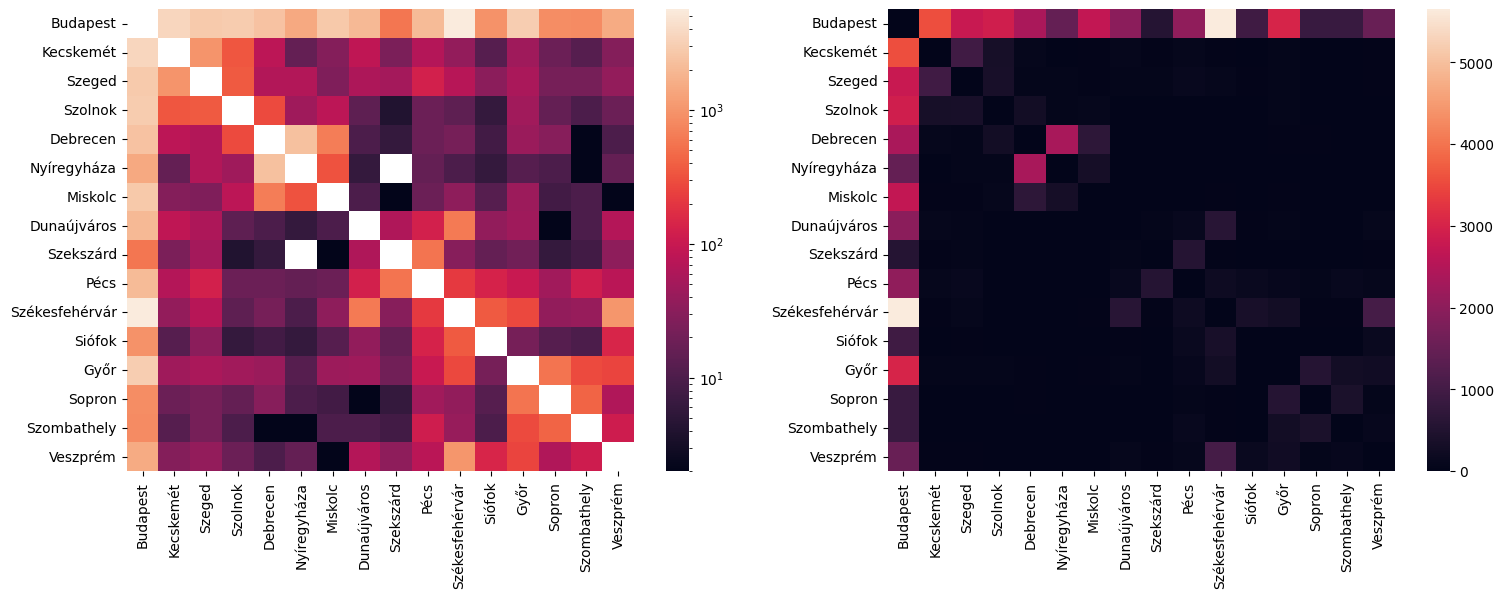

In [8]:
fig, ax = plt.subplots(1,2, figsize=(18,6))
computing_functions.plot_odm_axis(odm_2d_nondiagonal, cities,log_scale=True, ax=ax[0])
computing_functions.plot_odm_axis(odm_2d_nondiagonal, cities,log_scale=False, ax=ax[1])

## Compare the computed ODMs 

In [9]:
odm_gravity_base = computing_functions.odm_location_names_df_to_odm_2d_symmetric(gravity_base, cities)
odm_gravity_fitted = computing_functions.odm_location_names_df_to_odm_2d_symmetric(gravity_fitted, cities)
odm_entropy_max = computing_functions.odm_location_names_df_to_odm_2d_symmetric(entopy_max, cities)
odm_entropy_min = computing_functions.odm_location_names_df_to_odm_2d_symmetric(entopy_min, cities)

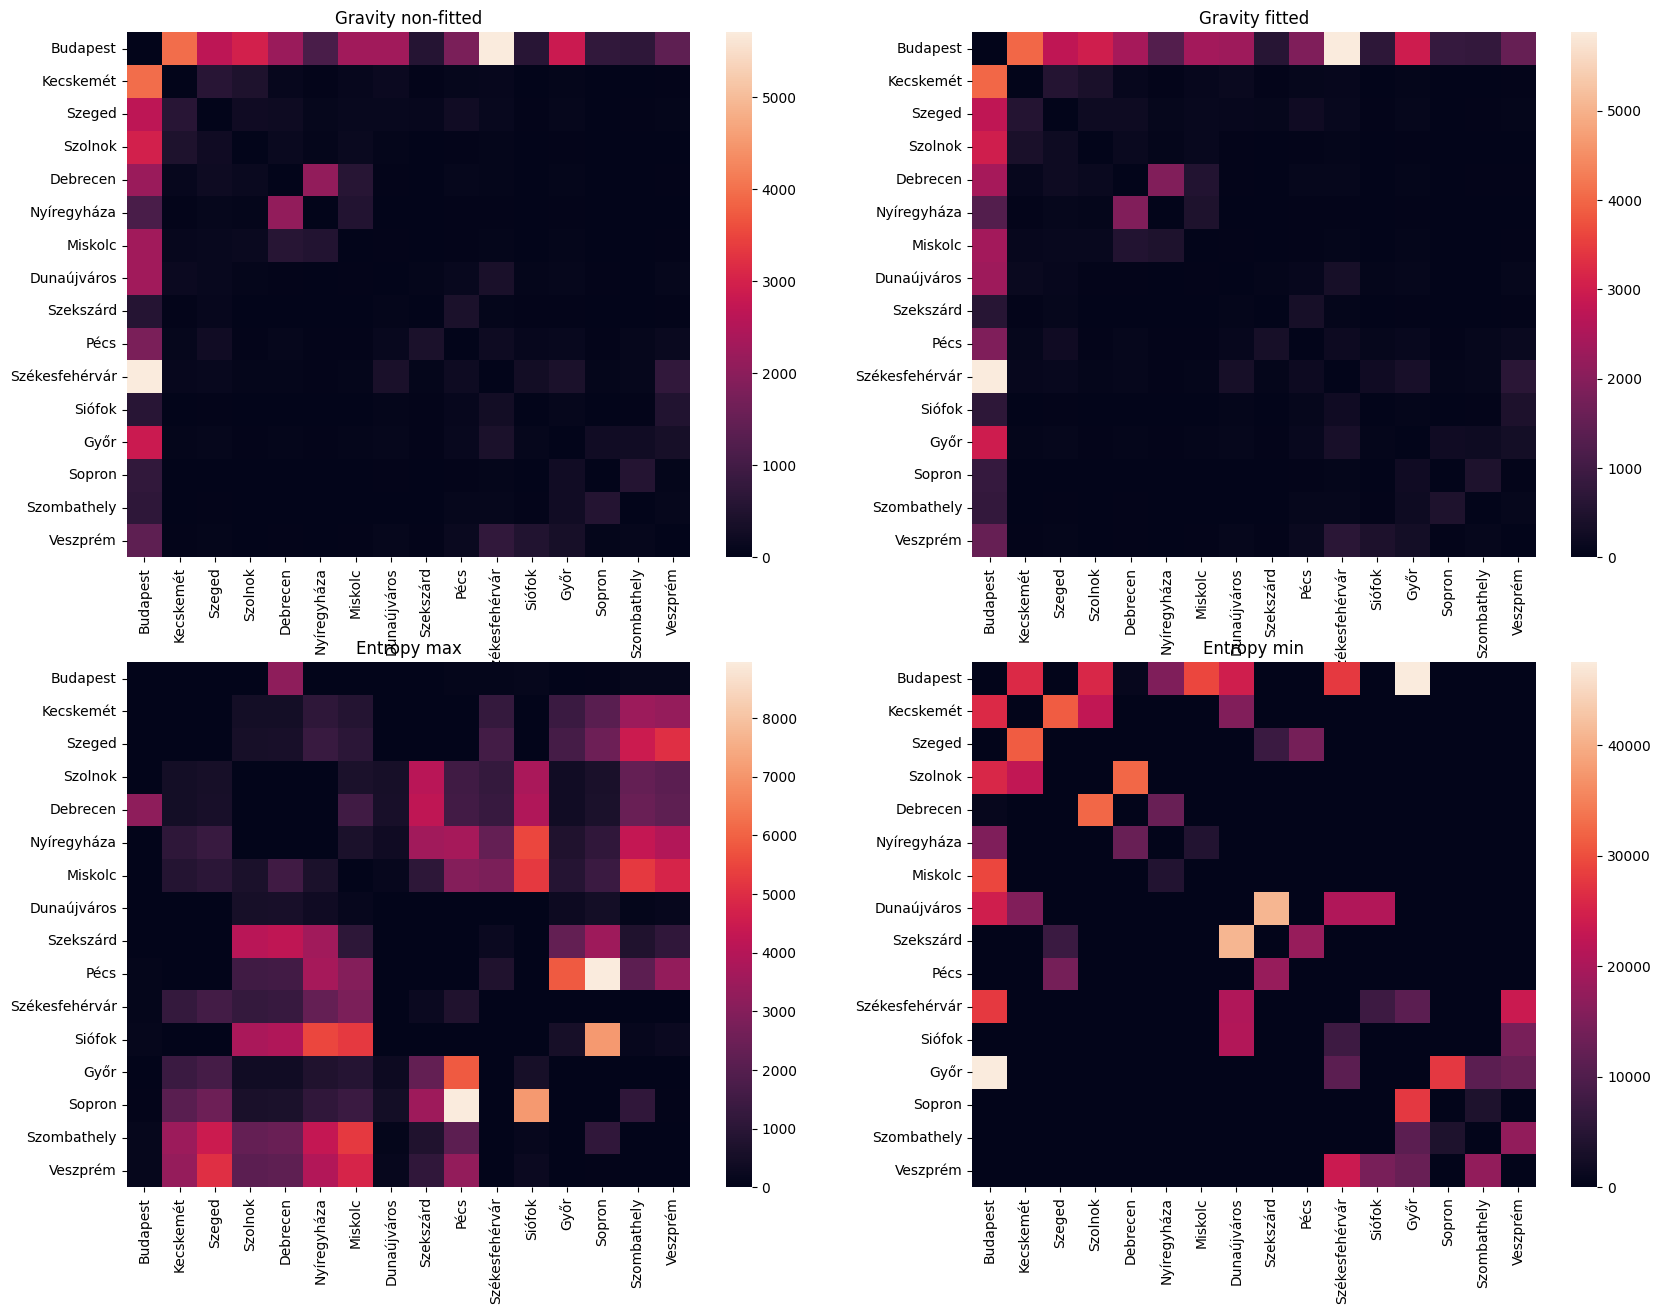

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
computing_functions.plot_odm_axis(odm_gravity_base, cities, ax=axs[0, 0])
computing_functions.plot_odm_axis(odm_gravity_fitted, cities, ax=axs[0, 1])
computing_functions.plot_odm_axis(odm_entropy_max, cities, ax=axs[1, 0])
computing_functions.plot_odm_axis(odm_entropy_min, cities, ax=axs[1, 1])

axs[0, 0].set_title('Gravity non-fitted')
axs[0, 1].set_title('Gravity fitted')
axs[1, 0].set_title('Entropy max')
axs[1, 1].set_title('Entropy min');


Difference plots:

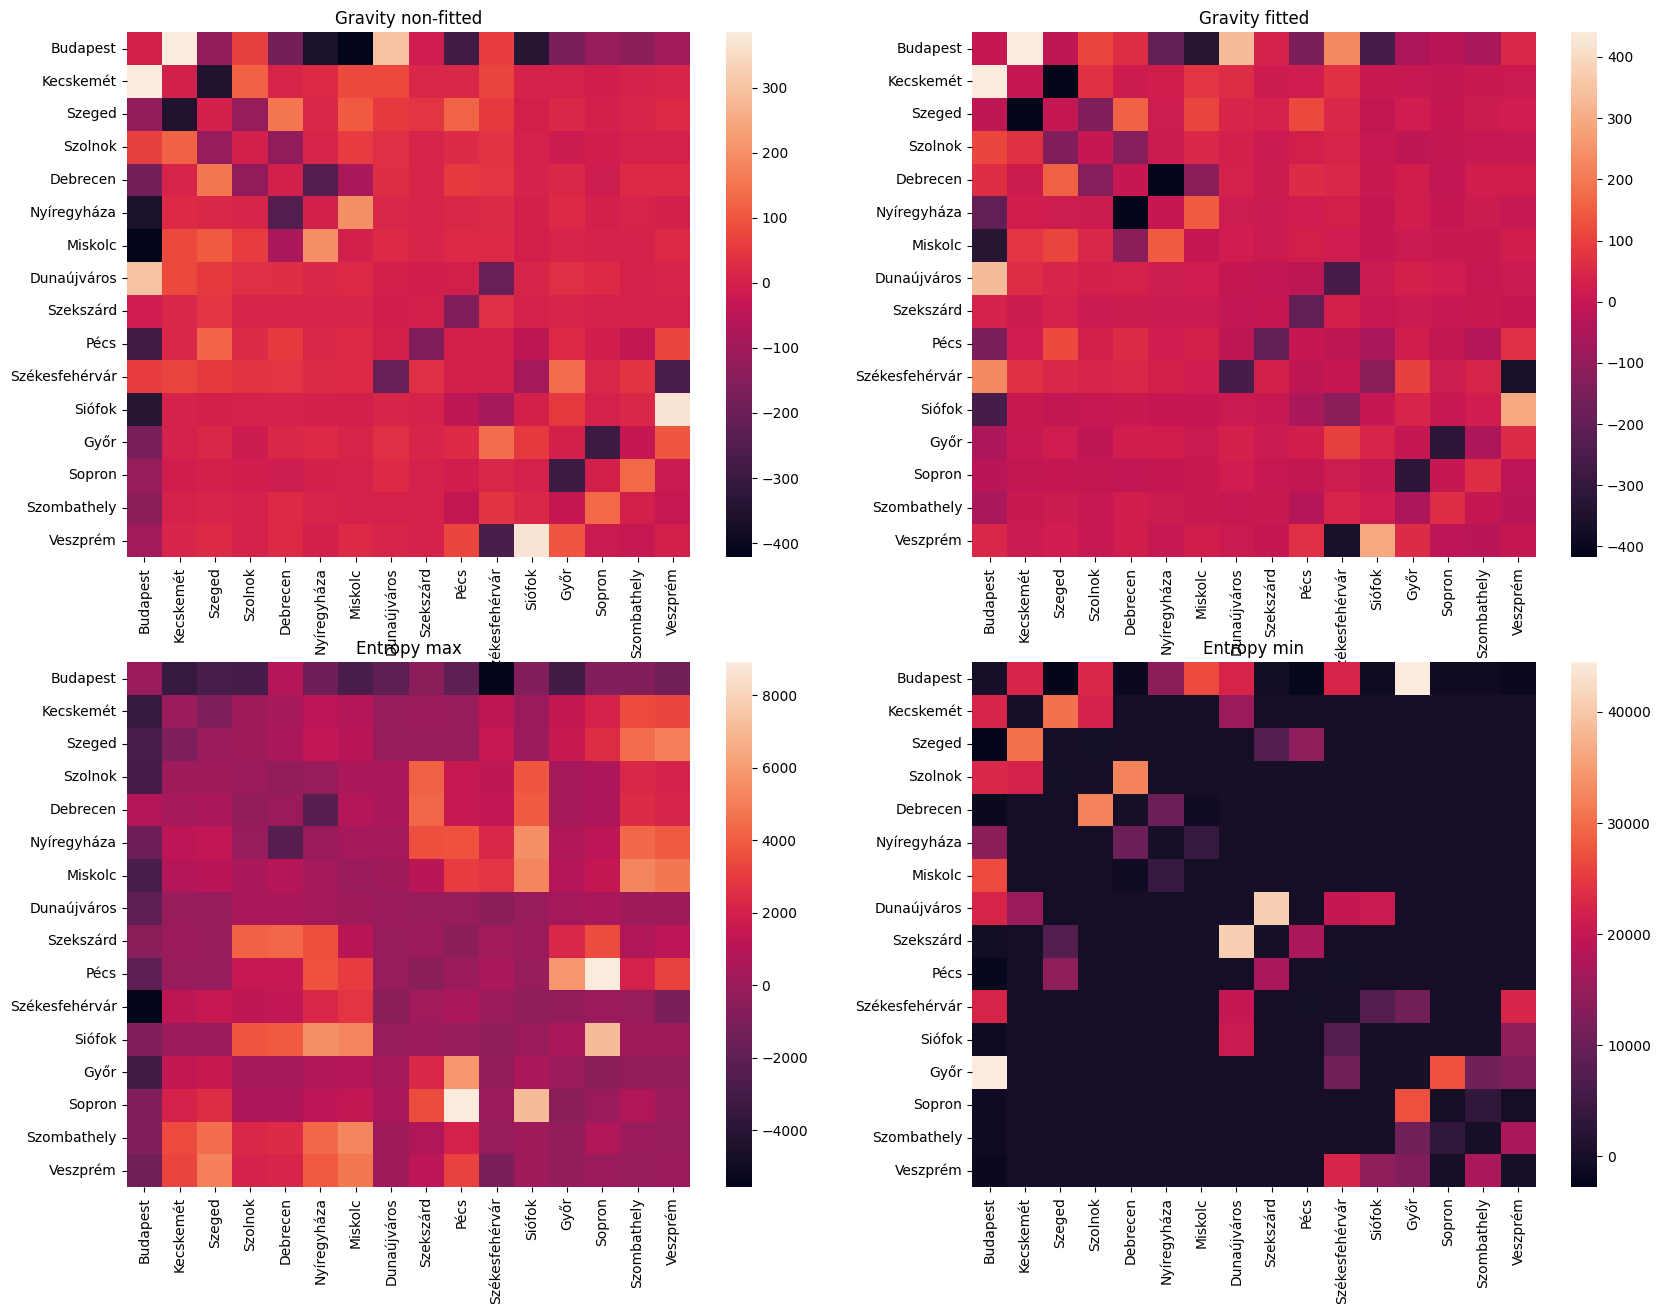

In [11]:
#Plot the 4 ODMs in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
computing_functions.plot_odm_axis(odm_gravity_base-odm_2d_nondiagonal, cities, ax=axs[0, 0])
computing_functions.plot_odm_axis(odm_gravity_fitted-odm_2d_nondiagonal, cities, ax=axs[0, 1])
computing_functions.plot_odm_axis(odm_entropy_max-odm_2d_nondiagonal, cities, ax=axs[1, 0])
computing_functions.plot_odm_axis(odm_entropy_min-odm_2d_nondiagonal, cities, ax=axs[1, 1])

#Set titles
axs[0, 0].set_title('Gravity non-fitted')
axs[0, 1].set_title('Gravity fitted')
axs[1, 0].set_title('Entropy max')
axs[1, 1].set_title('Entropy min');


Normalize to equal total flow: Set the models to have equal total flow as the original odm_2d_nondiagonal

In [12]:
def set_total_flow(odm, total_flow):
    return odm/np.sum(odm)*total_flow

total_flow = np.sum(odm_2d_nondiagonal)
odm_gravity_base_normalized = set_total_flow(odm_gravity_base, total_flow)
odm_gravity_fitted_normalized = set_total_flow(odm_gravity_fitted, total_flow)
odm_entropy_max_normalized = set_total_flow(odm_entropy_max, total_flow)
odm_entropy_min_normalized = set_total_flow(odm_entropy_min, total_flow)

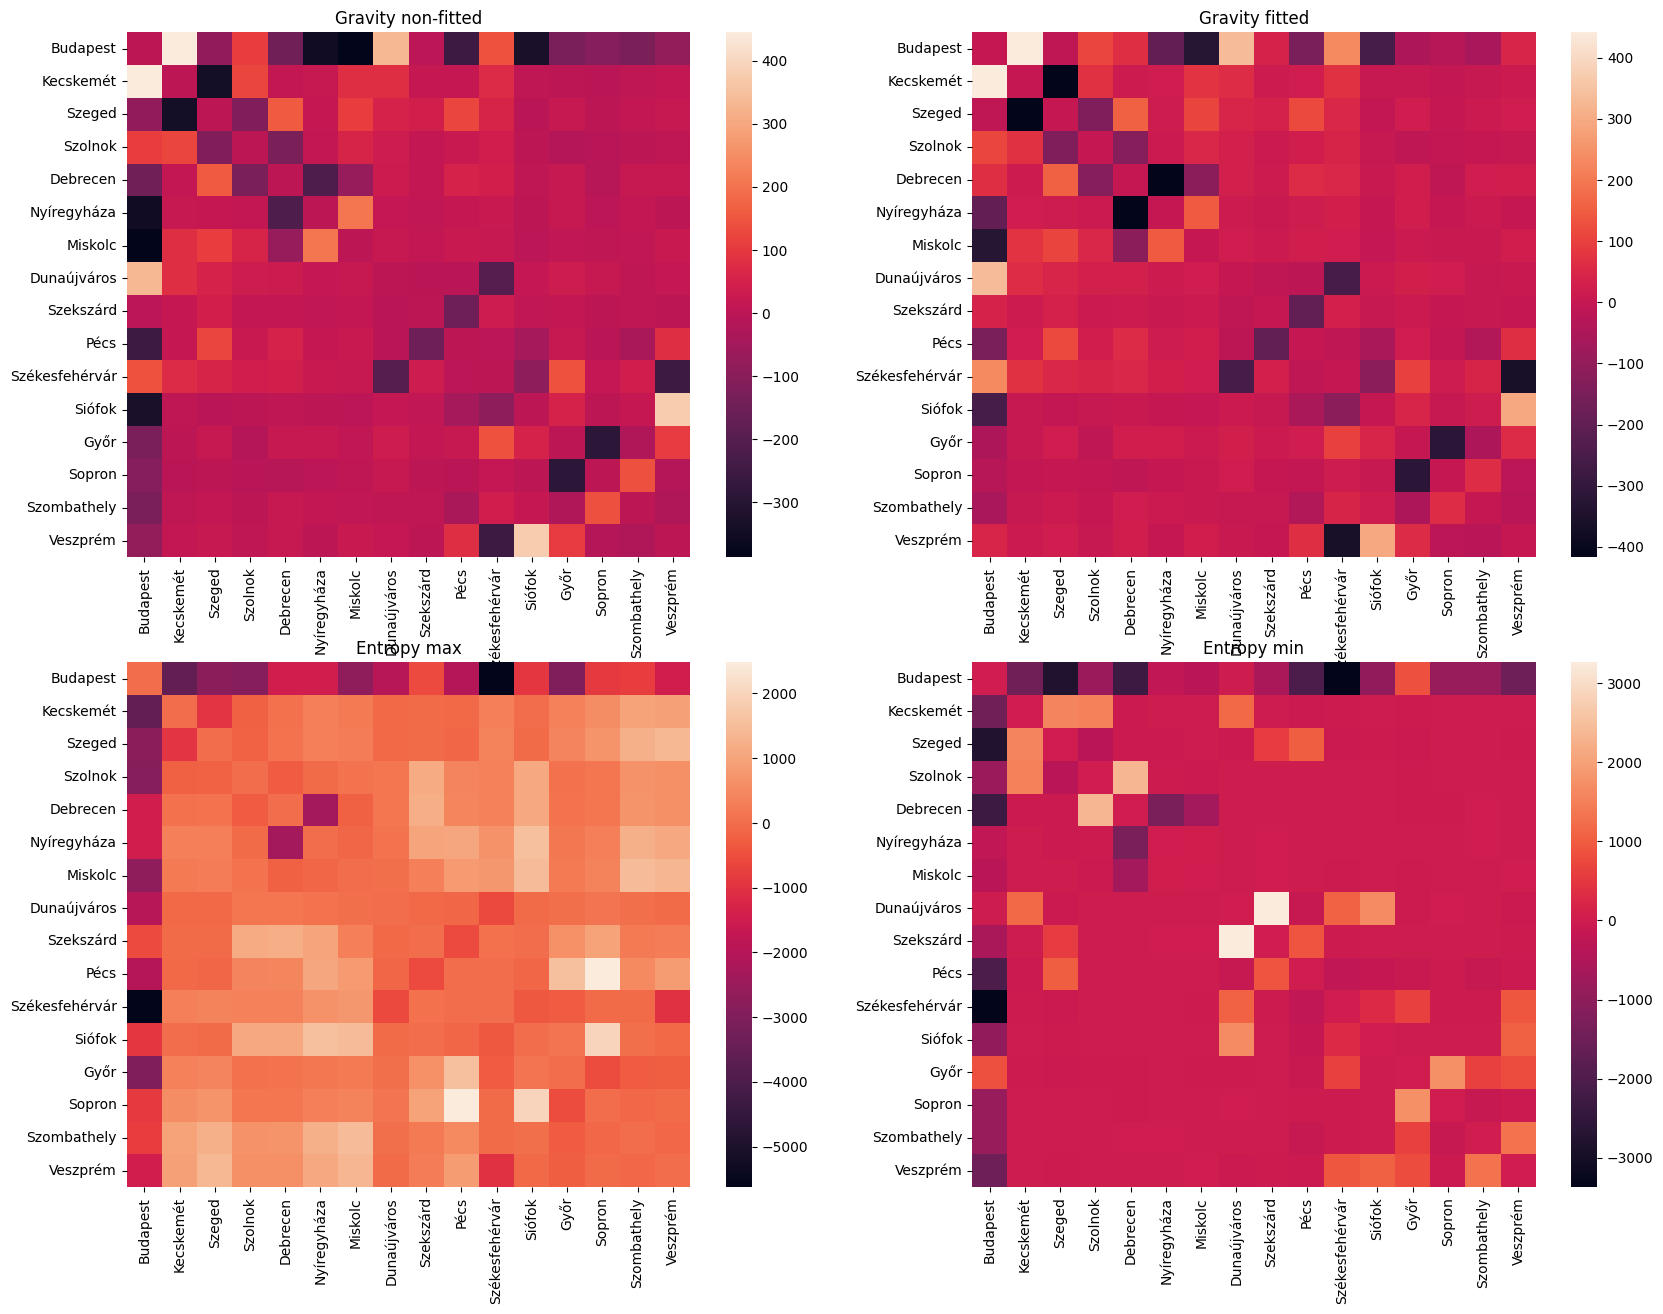

In [13]:
#Plot the 4 ODMs in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
computing_functions.plot_odm_axis(odm_gravity_base_normalized-odm_2d_nondiagonal, cities, ax=axs[0, 0])
computing_functions.plot_odm_axis(odm_gravity_fitted_normalized-odm_2d_nondiagonal, cities, ax=axs[0, 1])
computing_functions.plot_odm_axis(odm_entropy_max_normalized-odm_2d_nondiagonal, cities, ax=axs[1, 0])
computing_functions.plot_odm_axis(odm_entropy_min_normalized-odm_2d_nondiagonal, cities, ax=axs[1, 1])

#Set titles
axs[0, 0].set_title('Gravity non-fitted')
axs[0, 1].set_title('Gravity fitted')
axs[1, 0].set_title('Entropy max')
axs[1, 1].set_title('Entropy min');


We can see that the gravity model using the KSH data fits very well, surprisingly the power-law deterrence function works very well on large cities. On the other hand, the entropy minimizing model is very basic and does not use KSH data, and yet it still does fairly well.

In [14]:
mse_gravity, corr_gravity, sos_gravity = computing_functions.evaluate_model(odm_gravity_base_normalized, odm_2d_nondiagonal, "Gravity non-fitted", verbose=True)
mse_gravity_fitted, corr_gravity_fitted, sos_gravity_fitted = computing_functions.evaluate_model(odm_gravity_fitted_normalized, odm_2d_nondiagonal, "Gravity fitted", verbose=True)
mse_entropy_max, corr_entropy_max, sos_entropy_max = computing_functions.evaluate_model(odm_entropy_max_normalized, odm_2d_nondiagonal, "Entropy max", verbose=True)
mse_entropy_min, corr_entropy_min, sos_entropy_min = computing_functions.evaluate_model(odm_entropy_min_normalized, odm_2d_nondiagonal, "Entropy min", verbose=True)

MSE for Gravity non-fitted: 12872.211972123763
Correlation for Gravity non-fitted: 0.9909595541523721
SoS of relative differences for Gravity non-fitted: 1069.603155907657

MSE for Gravity fitted: 12585.918783906218
Correlation for Gravity fitted: 0.991304938939908
SoS of relative differences for Gravity fitted: 1122.7911558788546

MSE for Entropy max: 1154118.209642847
Correlation for Entropy max: -0.23136694449293665
SoS of relative differences for Entropy max: 2698347.0502437525

MSE for Entropy min: 593503.0654749919
Correlation for Entropy min: 0.5560296322943596
SoS of relative differences for Entropy min: 11324.71315676164



In [15]:
table = {
    'Model': ['Gravity non-fitted', 'Gravity fitted', 'Entropy max', 'Entropy min'],
    'MSE': [int(mse_gravity), int(mse_gravity_fitted), int(mse_entropy_max), int(mse_entropy_min)],
    'Correlation': [corr_gravity, corr_gravity_fitted, corr_entropy_max, corr_entropy_min],
    'SoS of relative differences': [int(sos_gravity), int(sos_gravity_fitted), int(sos_entropy_max), int(sos_entropy_min)],
    'Note': ['Geographical closeness bias', 'Not much difference to non-fitted', 'Bias on far distances', 'Bias on directly connected cities']
}

df = pd.DataFrame(table)
df

,Model,MSE,Correlation,SoS of relative differences,Note
0,Gravity non-fitted,12872,0.990960,1069,Geographical closeness bias
1,Gravity fitted,12585,0.991305,1122,Not much difference to non-fitted
2,Entropy max,1154118,-0.231367,2698347,Bias on far distances
3,Entropy min,593503,0.556030,11324,Bias on directly connected cities


In [16]:
qr1 = np.divide(odm_gravity_base_normalized, odm_2d_nondiagonal, where=odm_2d_nondiagonal!=0)
qr2 = np.divide(odm_gravity_fitted_normalized, odm_2d_nondiagonal, where=odm_2d_nondiagonal!=0)
qr1[5,8] = 0; qr1[8,5] = 0; qr2[5,8] = 0; qr2[8,5] = 0
np.fill_diagonal(qr1, 0); np.fill_diagonal(qr2, 0)

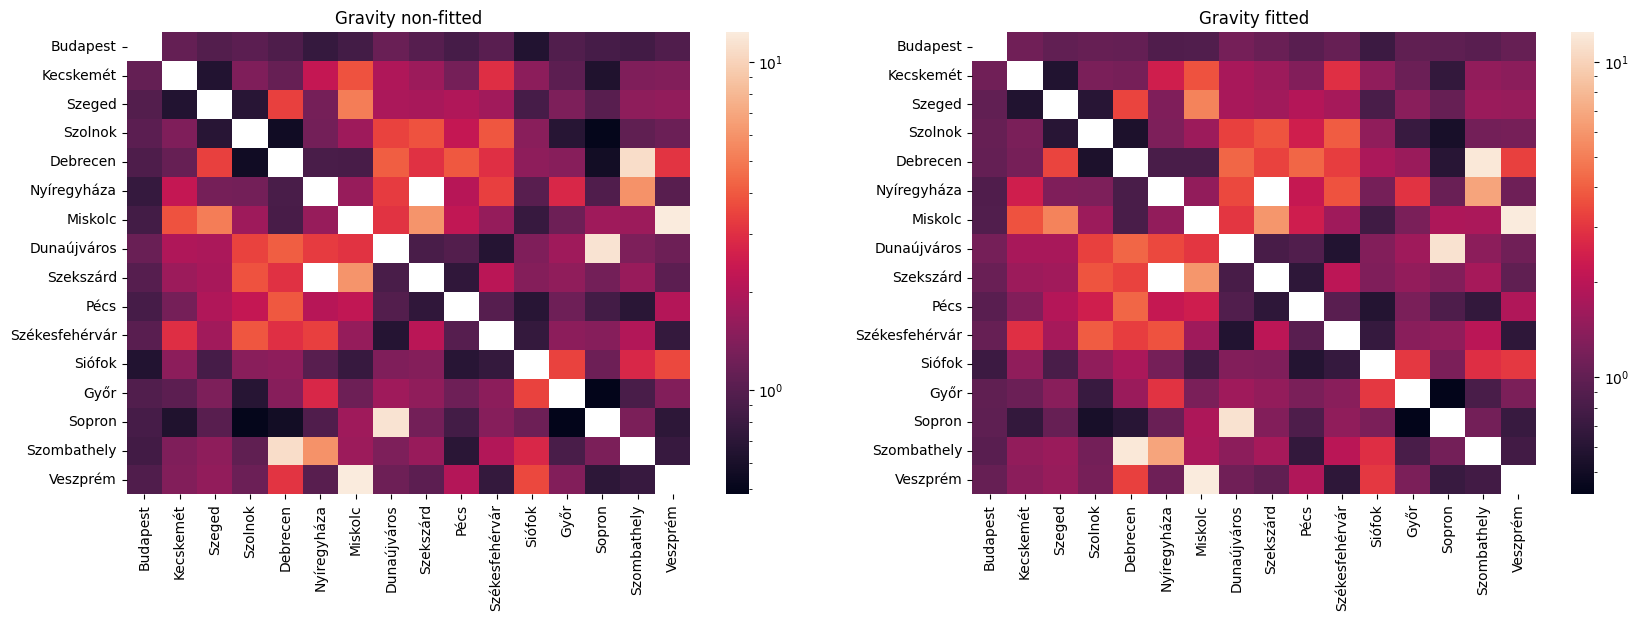

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
computing_functions.plot_odm_axis(qr1, cities, ax=axs[0], log_scale=True, title="Gravity non-fitted")
computing_functions.plot_odm_axis(qr2, cities, ax=axs[1], log_scale=True, title="Gravity fitted")

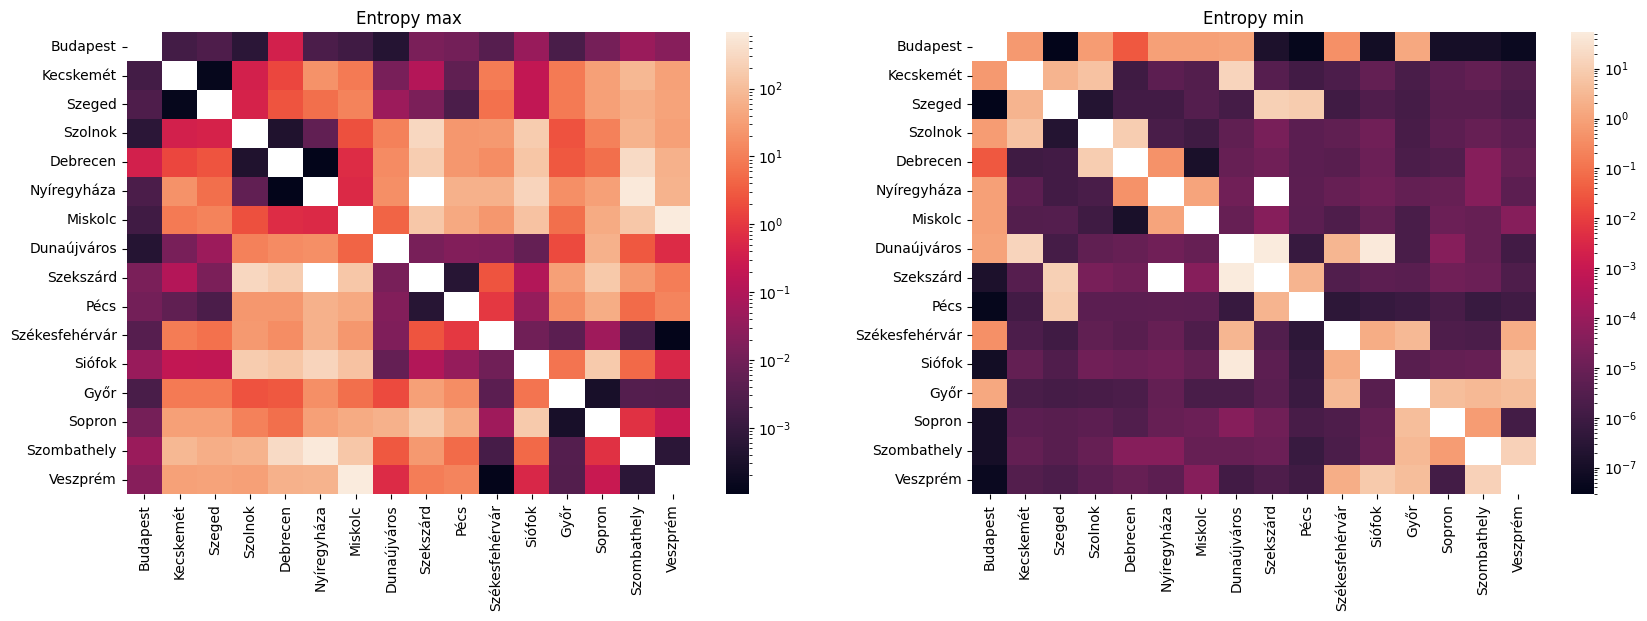

In [18]:
qr3 = np.divide(odm_entropy_max_normalized, odm_2d_nondiagonal, where=odm_2d_nondiagonal!=0)
qr4 = np.divide(odm_entropy_min_normalized, odm_2d_nondiagonal, where=odm_2d_nondiagonal!=0)
qr3[5,8] = 0; qr3[8,5] = 0; qr4[5,8] = 0; qr4[8,5] = 0
np.fill_diagonal(qr3, 0); np.fill_diagonal(qr4, 0)

fig, axs = plt.subplots(1, 2, figsize=(20, 6))
computing_functions.plot_odm_axis(qr3, cities, ax=axs[0], log_scale=True, title="Entropy max")
computing_functions.plot_odm_axis(qr4, cities, ax=axs[1], log_scale=True, title="Entropy min")